# Using Recipe Ingredients to Categorize Cuisine

By Eka Renardi. October 20, 2015

## 1. Introduction

Kaggle posed a challenge for predicting the category of cuisine based on its recipe ingredients. This document outlines my approach for solving this Kaggle Competition, [What's Cooking](https://www.kaggle.com/c/whats-cooking). 

## 2. Dataset

*Yummly* graciously provided the dataset for this challenge. The dataset consists of train and test set. The train set listed the cuisines, and ingredients for the cuisine.  The test set data listed just the ingredients. A sample train data set is as follows:

```
{
    "id": 25693,
    "cuisine": "southern_us",
    "ingredients": [
      "plain flour",
      "ground pepper",
      "salt",
      "tomatoes",
      "ground black pepper",
      "thyme",
      "eggs",
      "green tomatoes",
      "yellow corn meal",
      "milk",
      "vegetable oil"
    ]
}
```

Attributes:

- "id" - unique identifier
- "cuisine" - category of a cuisine
- "ingredients" - ingredients used to make the cuisine


### 2.1 Data Import
Lets read it

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter, defaultdict
import seaborn as sns
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_selection import chi2, SelectPercentile, SelectKBest, f_classif
from sklearn.cross_validation import train_test_split, cross_val_score, KFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn import metrics
from scipy.stats import sem
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances, roc_curve, auc
from sklearn.datasets import make_classification
import matplotlib.pylab as pyl
from sklearn.ensemble import RandomForestClassifier

sns.set_style('whitegrid')

In [2]:
df = pd.read_json('../data/train.json')

## 3. Exploratory Statistics
In my attempt to understand the data, several exploratory statistics are constructed.

### 3.1. How many unique cuisines are there, and what are they?

('shape:', (39774, 3))
('unique cuisine count:', 20)


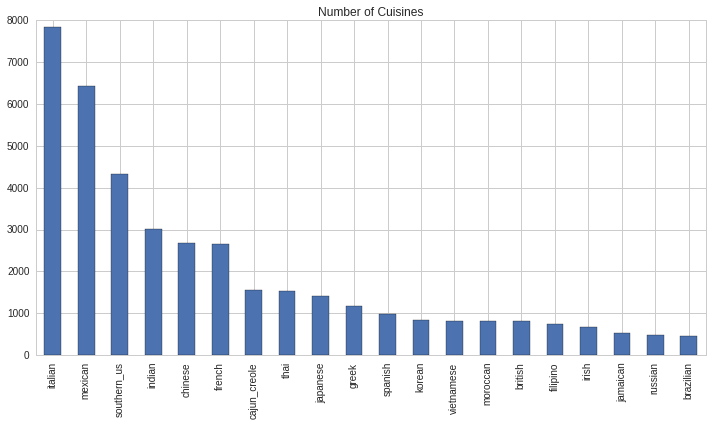

In [3]:
cuisines = df.cuisine.value_counts(sort=True)
cuisines.plot(kind="bar", figsize=(12,6), title="Number of Cuisines")
print("shape:", df.shape)
print("unique cuisine count:", len(df.cuisine.unique()))

### 3.2. What is the most often used ingredients by all cuisine? and what is the most often used ingredients for each cuisine?

In [4]:
# calculating the usage of each ingredient, and for each cuisine
cuisine_dict = defaultdict(Counter)
index_dict = defaultdict(Counter)
total_counter = Counter()
# iterate each row
for index, row in df.iterrows():
    # get the counters
    row_counter = index_dict[row.id] 
    local_counter = cuisine_dict[row.cuisine]
    # count the ingredients usage
    arr = row.ingredients
    for ingredient in row.ingredients:
        key = ingredient.lower()
        # increment each word count
        total_counter[key] += 1
        local_counter[key] += 1
        row_counter[key] += 1
    # update the counters
    cuisine_dict[row.cuisine] = local_counter
    index_dict[row.id] = row_counter
    

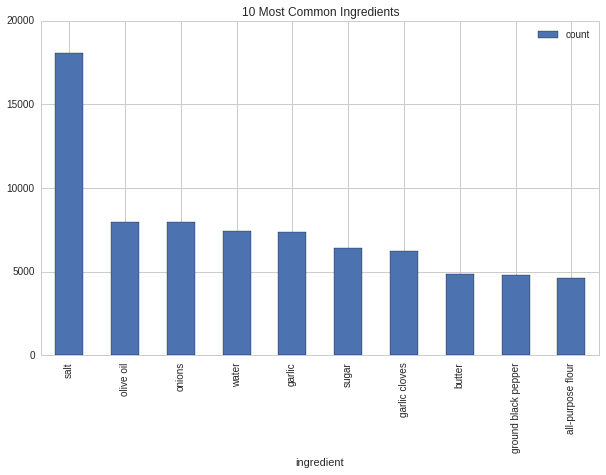

In [5]:
# plotting most common ingredients
most_common_ingredients = pd.DataFrame(total_counter.most_common(10), columns=["ingredient", "count"])
most_common_ingredients.plot(kind="bar", x="ingredient", figsize=(10,6), title="10 Most Common Ingredients")   

Let's draw a word cloud for top 100 ingredients.

/home/morita/anaconda/lib/python2.7/site-packages/PIL/ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


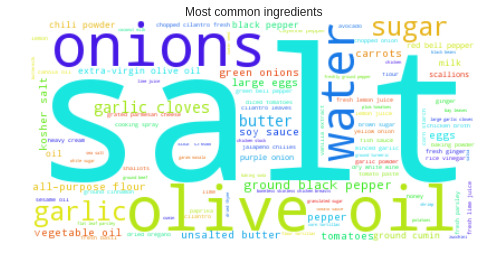

In [6]:
from wordcloud import WordCloud
wordcloudobj = WordCloud( background_color='white')
wordcloud = wordcloudobj.generate_from_frequencies(total_counter.most_common(100))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Most common ingredients")
plt.show()

Now let's look at the 100 most common ingredients used for each cuisine

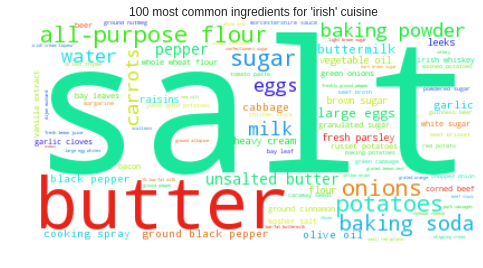

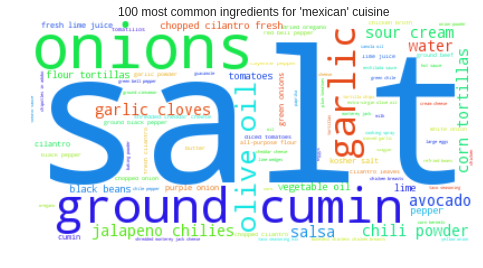

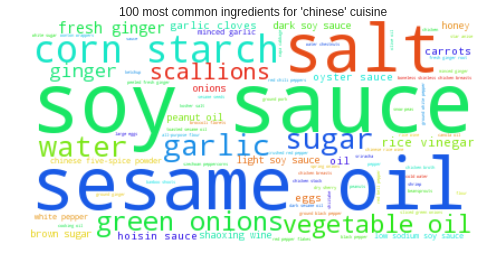

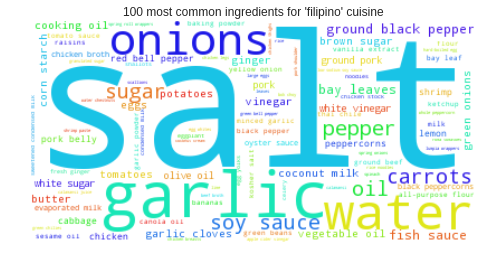

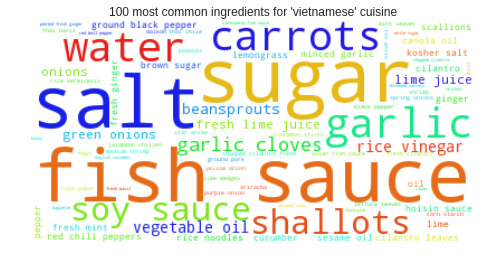

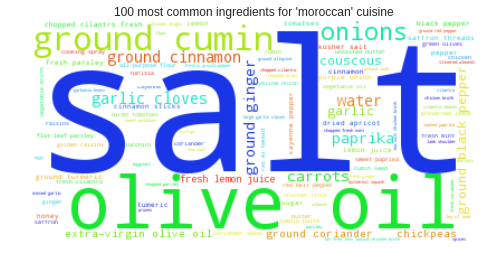

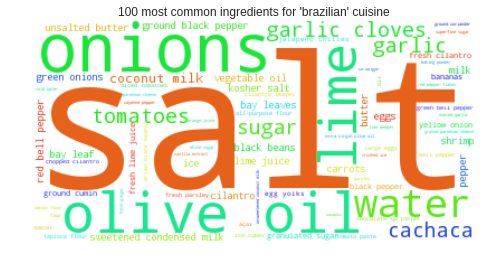

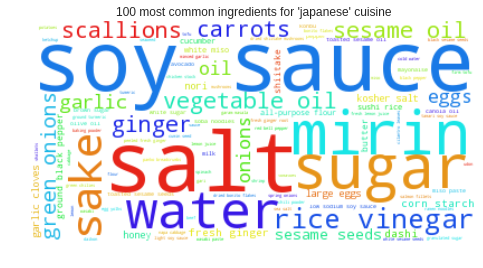

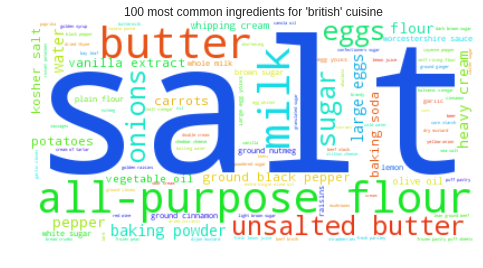

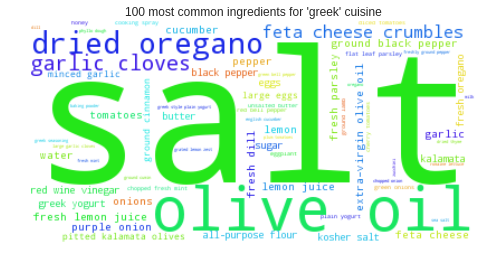

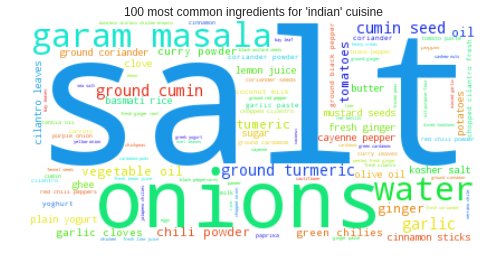

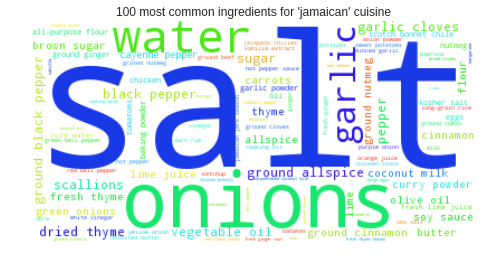

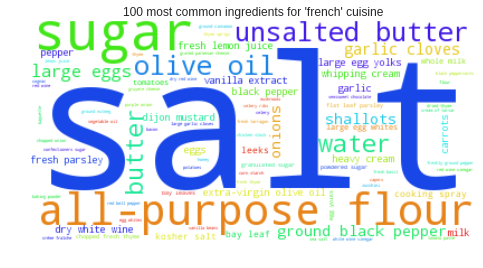

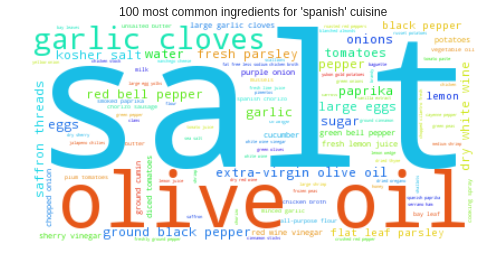

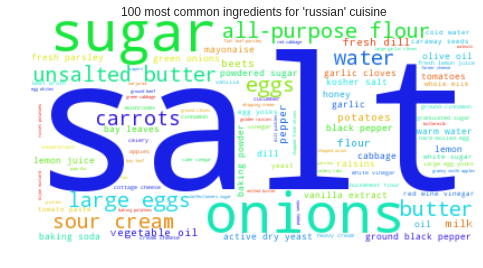

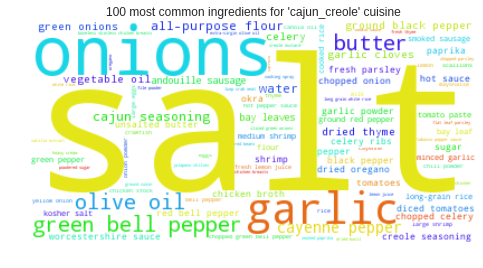

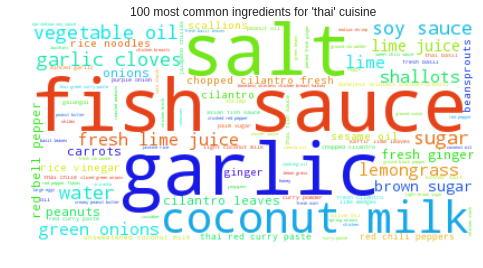

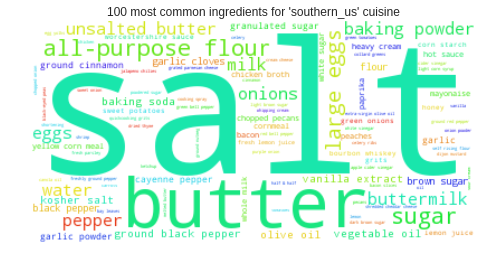

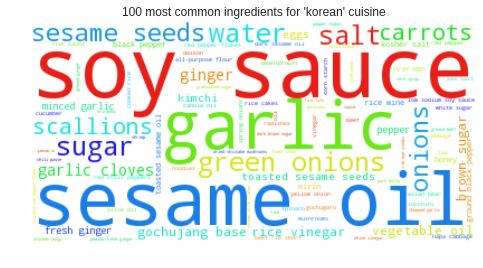

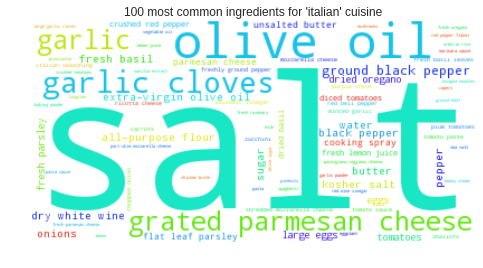

In [7]:
for key, value in cuisine_dict.iteritems():
    wc = wordcloudobj.generate_from_frequencies(value.most_common(100))
    plt.imshow(wc)
    plt.title("100 most common ingredients for '%s' cuisine" % key)
    plt.axis("off")
    plt.show()    

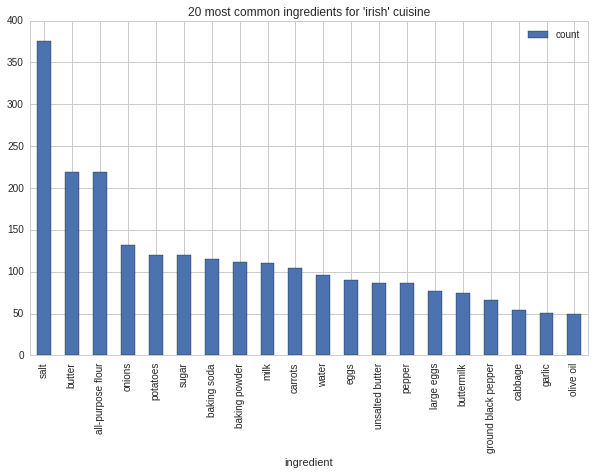

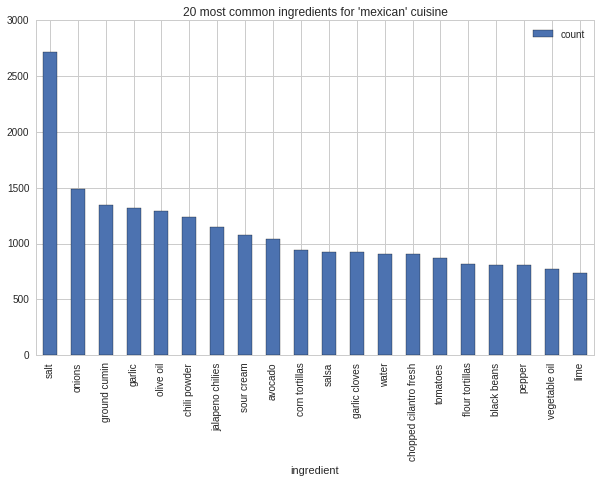

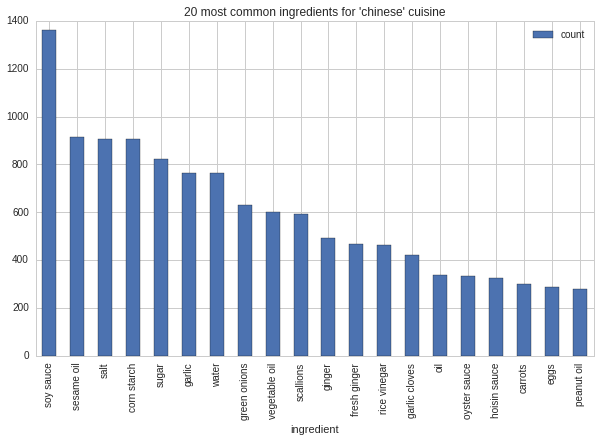

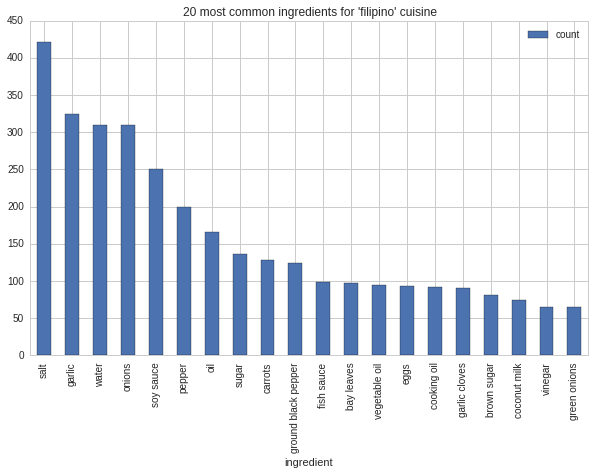

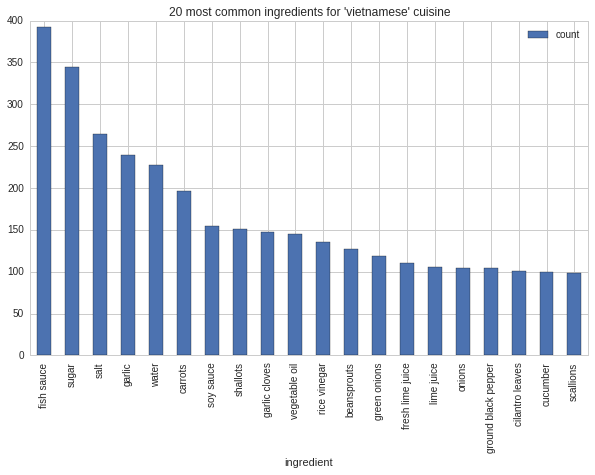

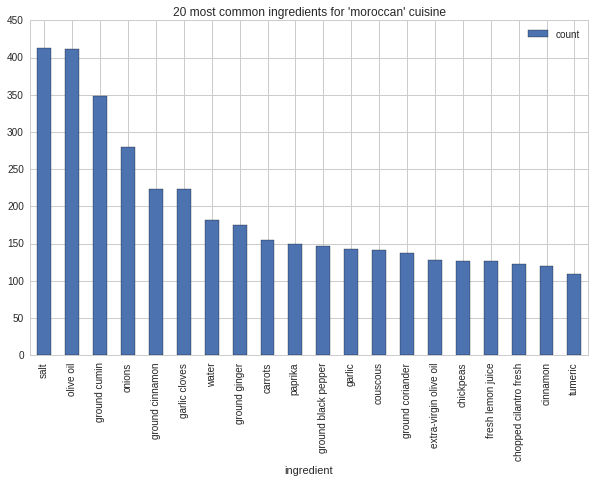

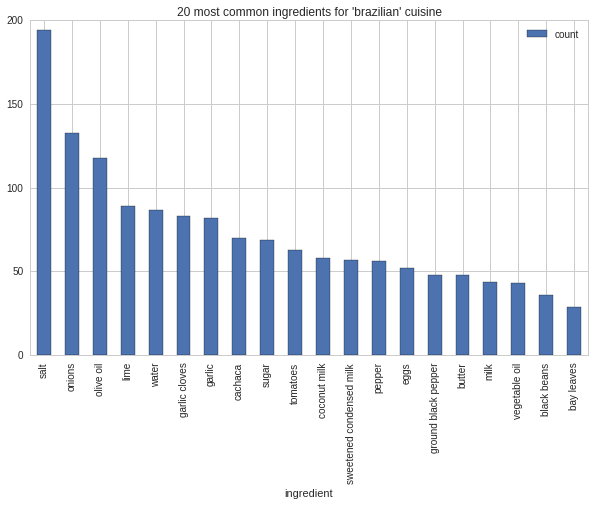

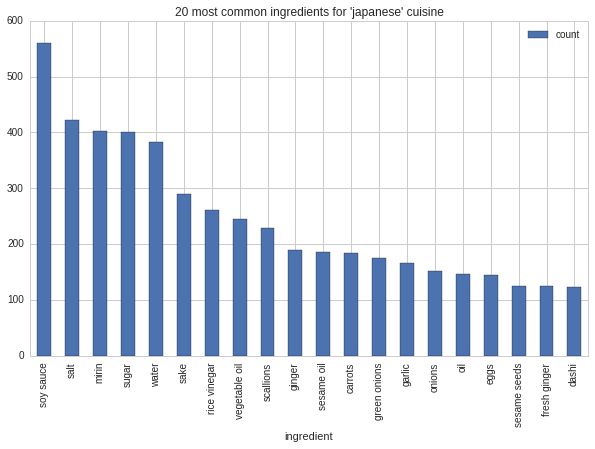

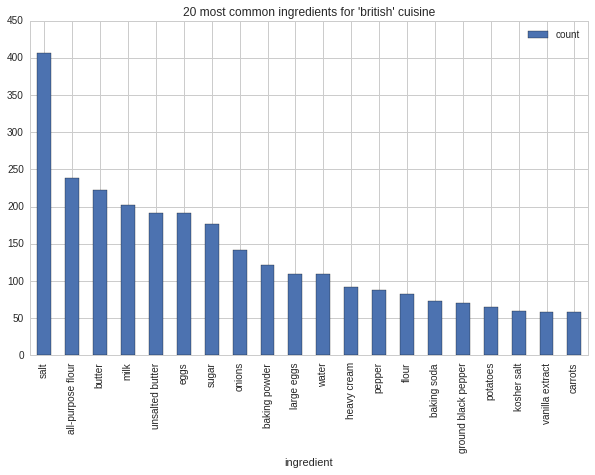

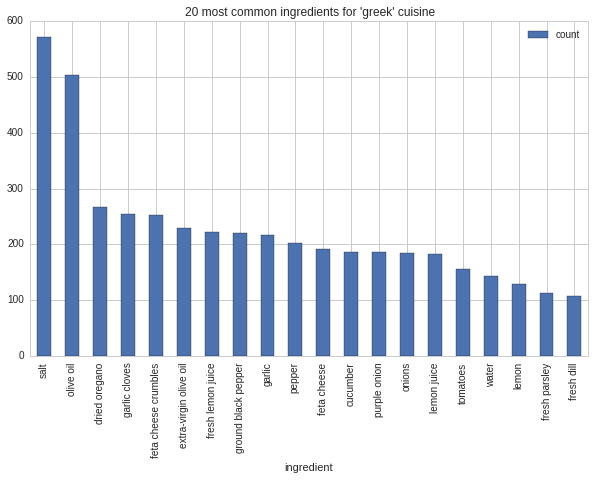

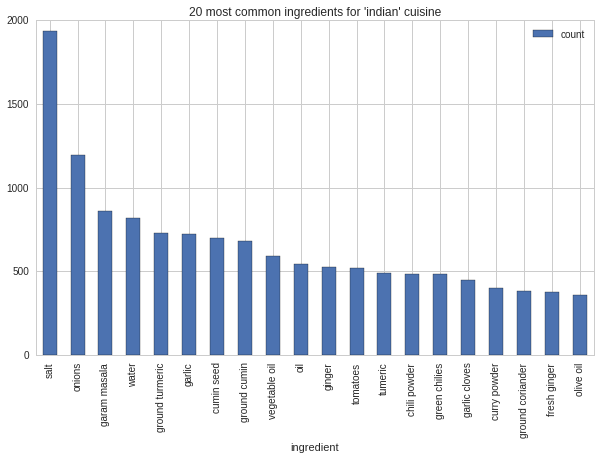

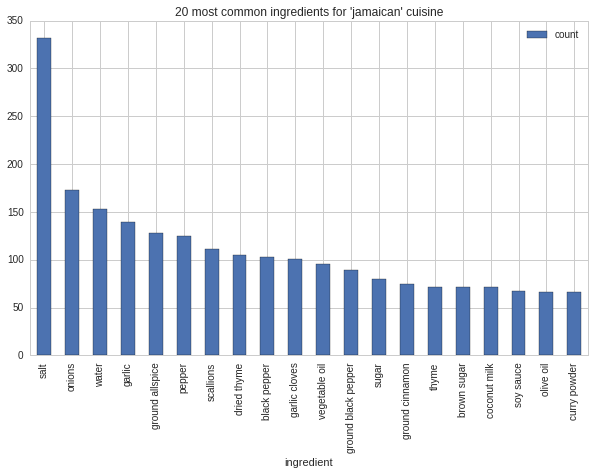

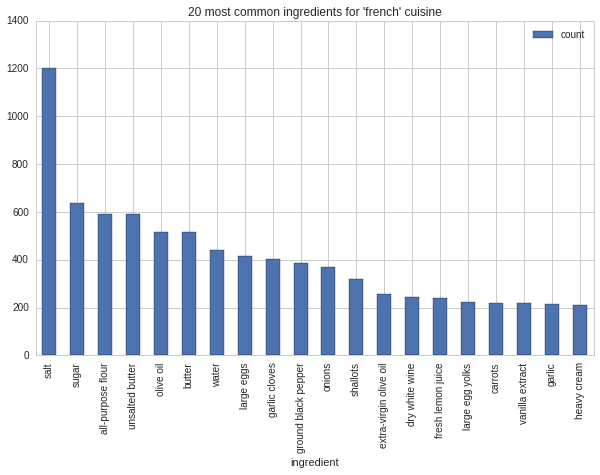

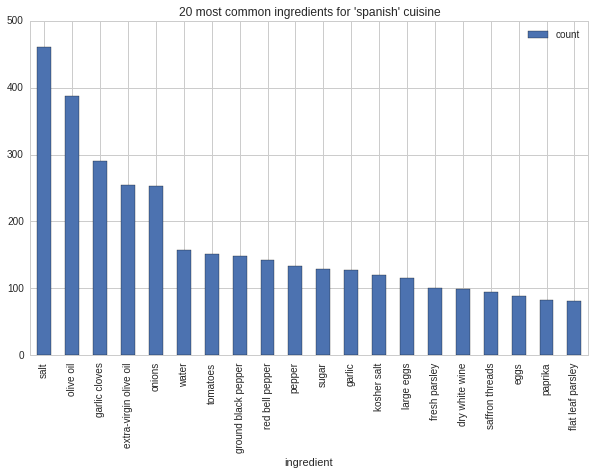

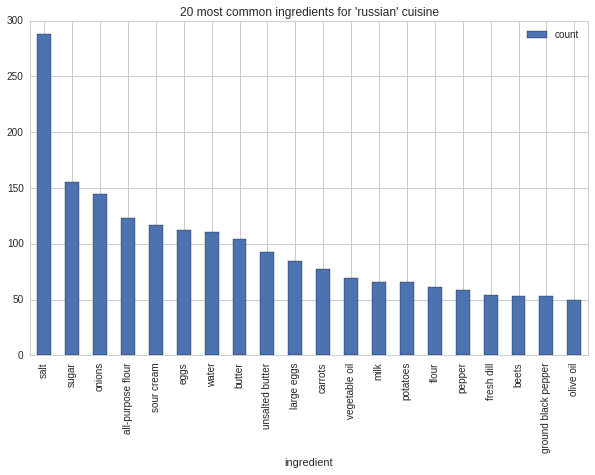

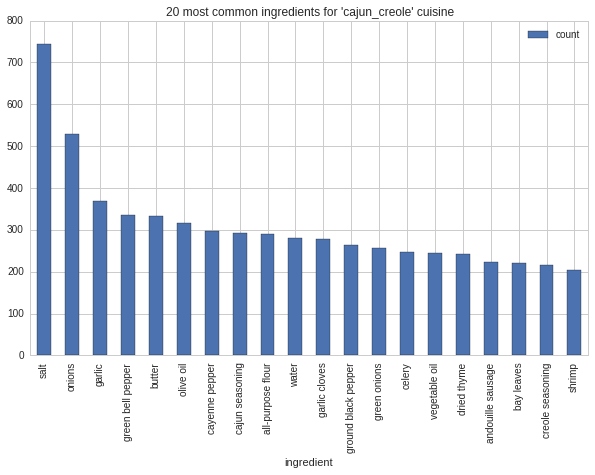

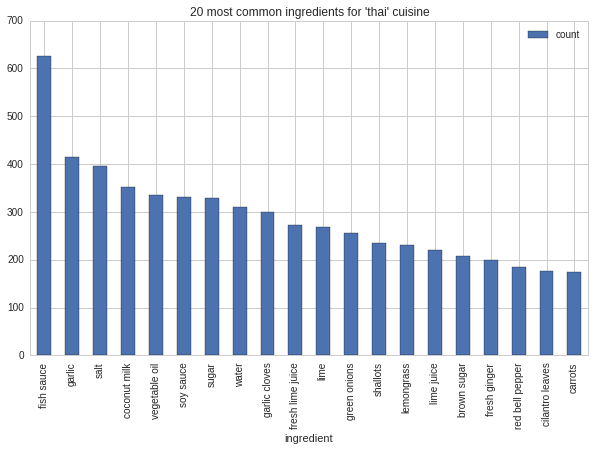

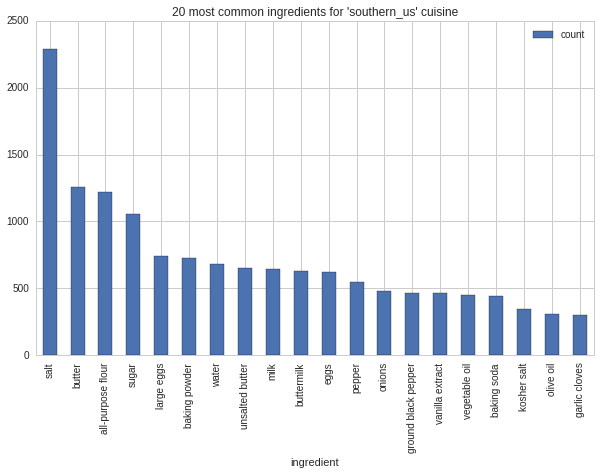

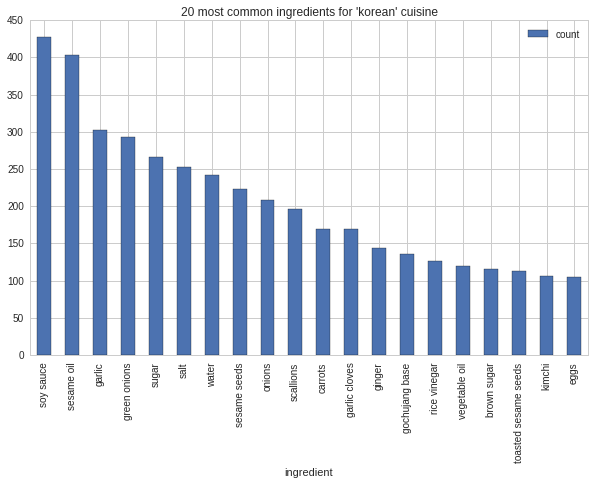

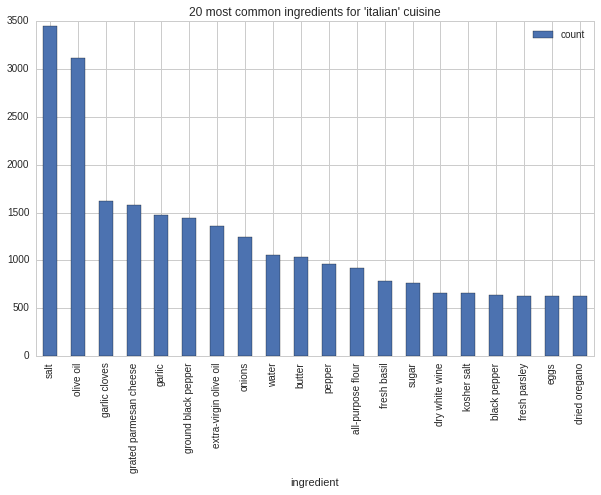

In [8]:
# bar char plot of top 20 most common ingredients
for key, value in cuisine_dict.iteritems():
    mc = pd.DataFrame(value.most_common(20), columns=["ingredient", "count"])
    mc.plot(kind="bar", x="ingredient", figsize=(10,6), title="20 Most Common Ingredients")   
    plt.title("20 most common ingredients for '%s' cuisine" % key)
    plt.show()   

### 3.3. What is the ngram range for each cuisine?

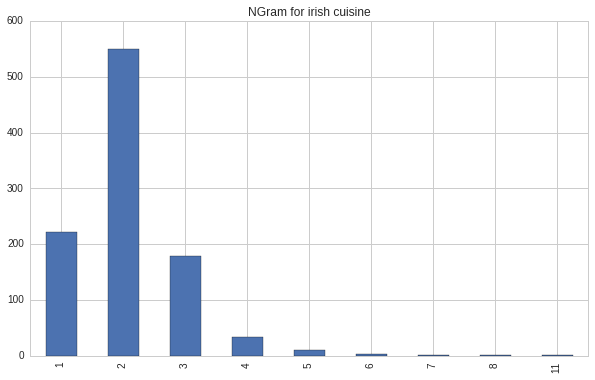

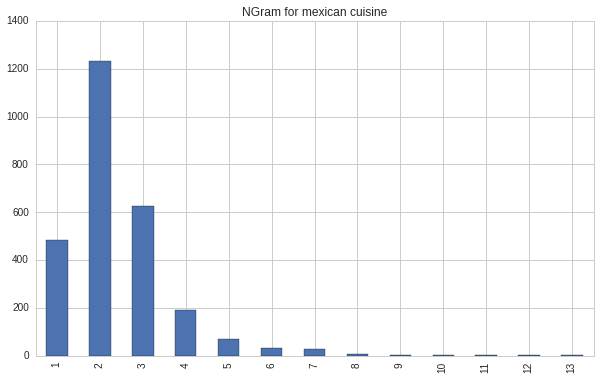

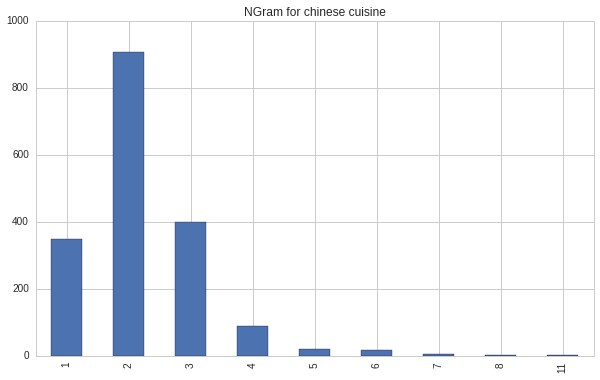

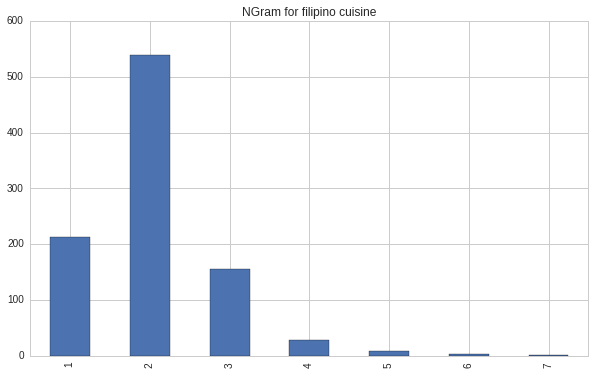

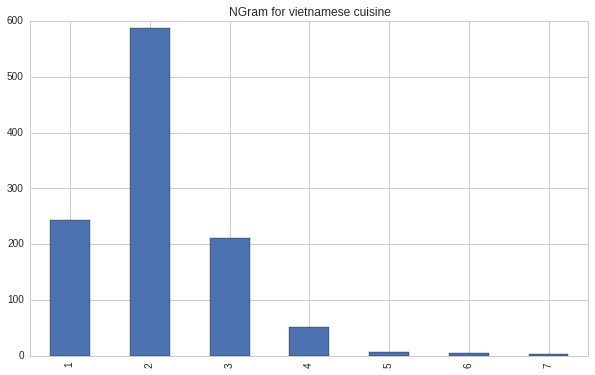

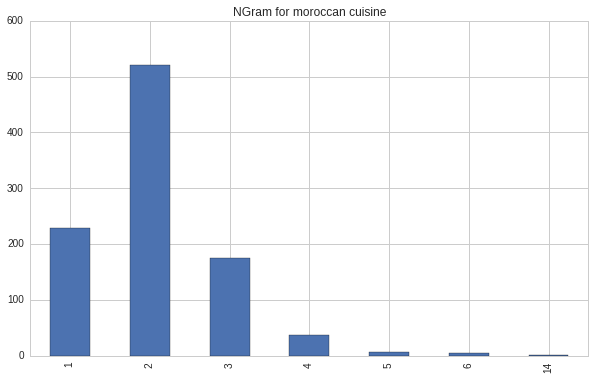

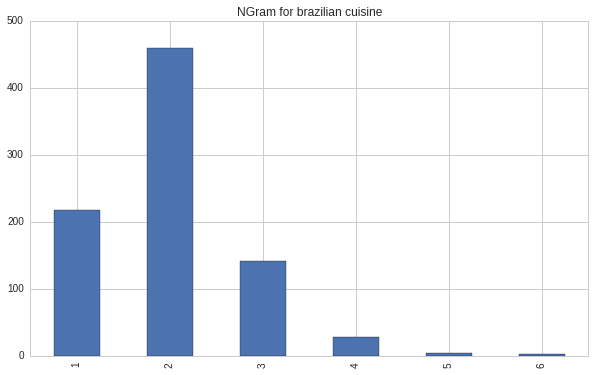

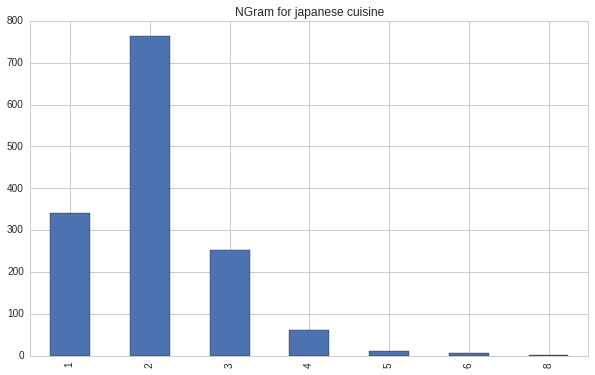

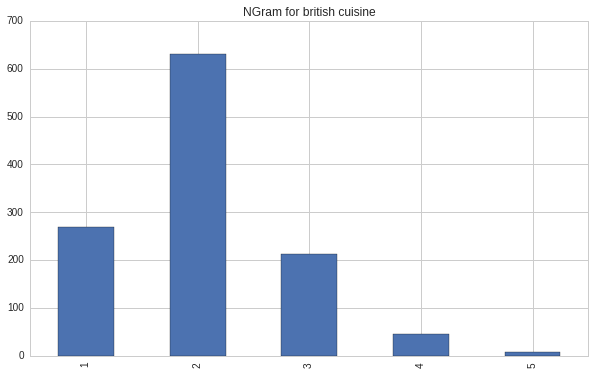

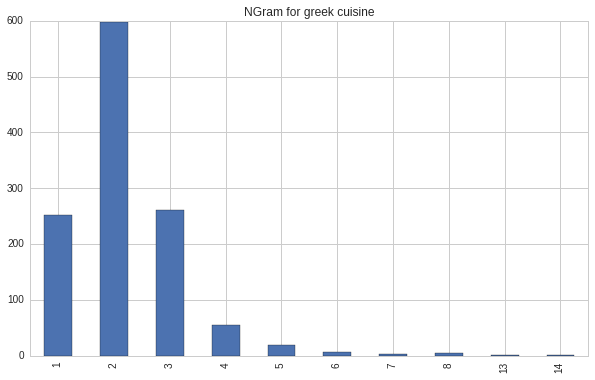

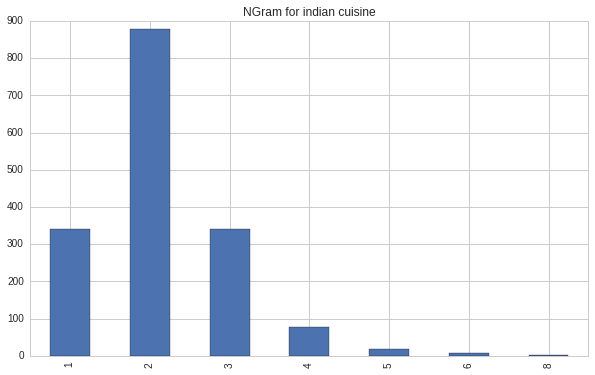

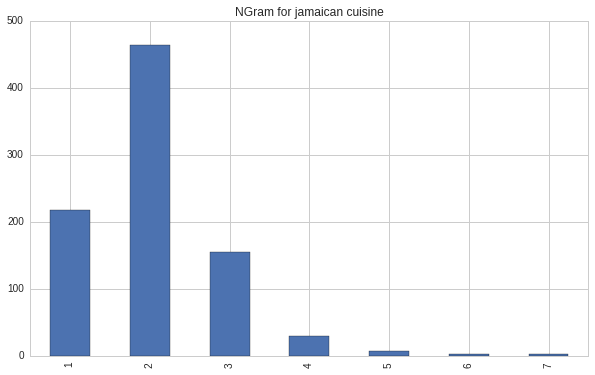

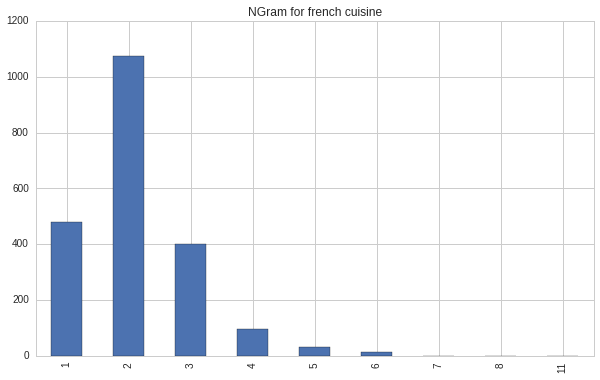

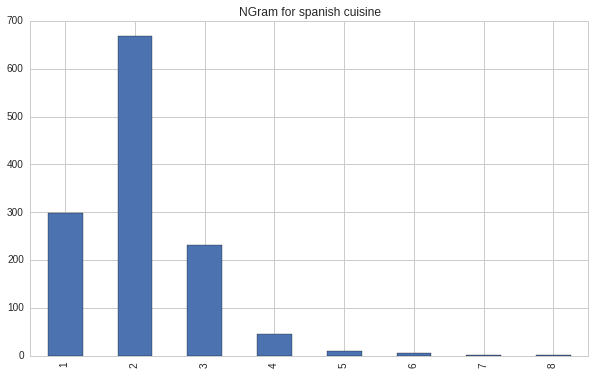

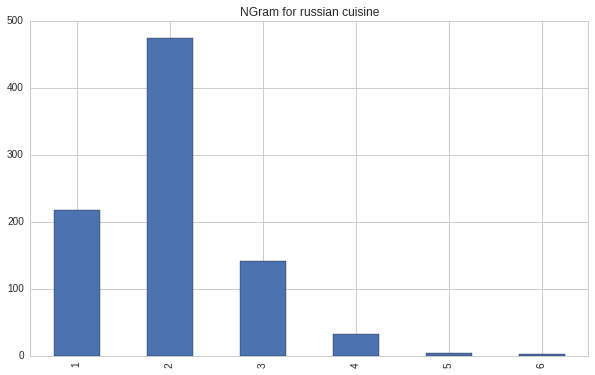

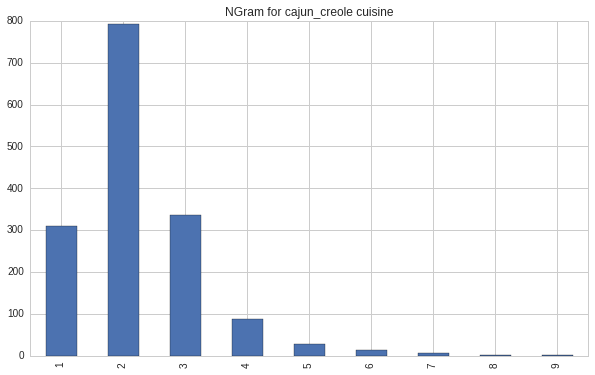

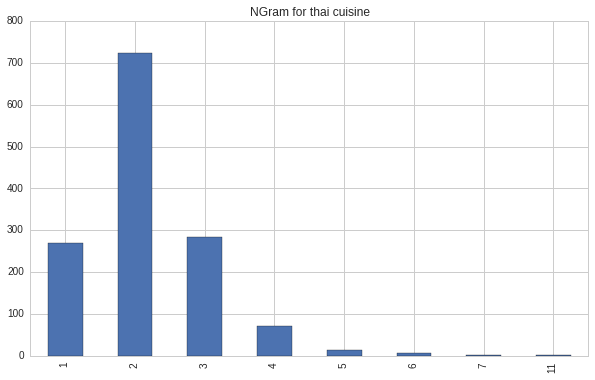

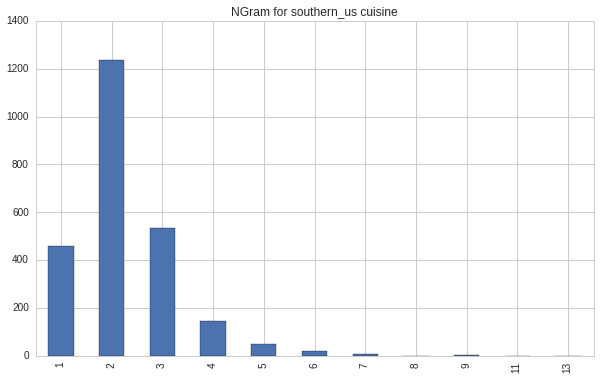

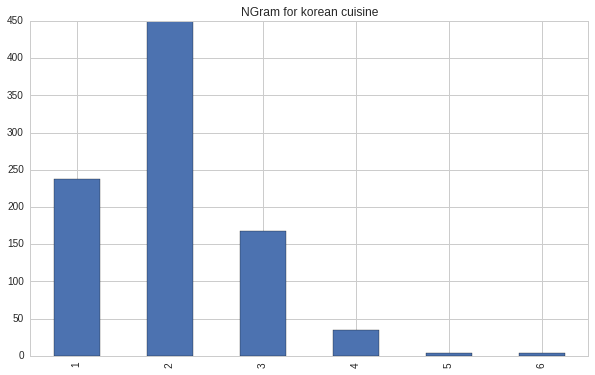

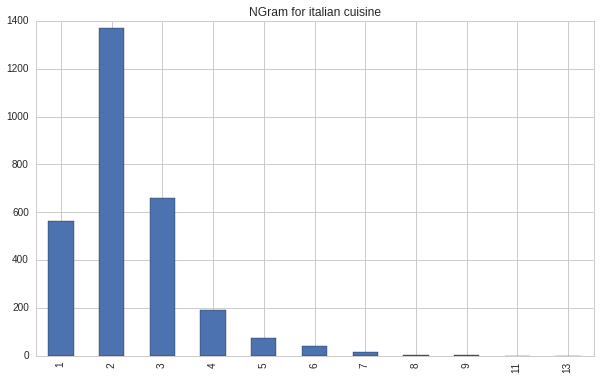

In [9]:
# ngram range for each cuisine
stemmer = PorterStemmer()
ngram_counters = {}
for key, value in cuisine_dict.iteritems():
    rng = [len(word_tokenize(stemmer.stem(wc))) for wc, val in value.iteritems()]  
    local_ngram_counter = Counter(rng)
    ngram_counters[key] = local_ngram_counter
    local_series = pd.Series(local_ngram_counter)
    local_series.plot(kind="bar", figsize=(10,6), title="NGram for %s cuisine" % key)  
    plt.show()



In [10]:
# vector of ngram for each cuisine
ngram_index = {}
for key, value in ngram_counters.iteritems():
    ngram_index[key] = dict(value)
df_ngram = pd.DataFrame.from_dict(ngram_index, orient='index')
df_ngram = df_ngram.fillna(0)
df_ngram

,1,2,3,4,5,6,7,8,11,9,10,12,13,14
brazilian,217,459,142,28,4,3,0,0,0,0,0,0,0,0
british,269,630,213,46,7,0,0,0,0,0,0,0,0,0
cajun_creole,309,793,336,87,27,14,6,1,0,2,0,0,0,0
chinese,348,908,401,90,21,16,4,2,1,0,0,0,0,0
filipino,213,539,155,28,8,3,1,0,0,0,0,0,0,0
french,478,1074,402,97,33,13,1,1,1,0,0,0,0,0
greek,252,597,260,54,19,7,3,4,0,0,0,0,1,1
indian,341,878,340,78,19,7,0,1,0,0,0,0,0,0
irish,221,549,178,34,11,3,1,1,1,0,0,0,0,0
italian,564,1370,660,190,76,42,14,5,1,5,0,0,1,0


### 3.4 Are there groupings between ingredients and cuisines?

In [11]:
# get a vector of cuisines and ingredients
index1 = {}
for key, value in cuisine_dict.iteritems():
    index1[key] = dict(value)
df1 = pd.DataFrame.from_dict(index1, orient='index')
df1 = df1.fillna(0)
cuisine_labels = [key for key, value in df1.iterrows()]
ingredients_labels = list(df1.columns)

# calculating the table of probabilities for the cuisines
inst_count=df1.sum(axis='columns')
df1_prob= df1.div(inst_count,axis='rows')

In [12]:
mds = MDS(n_components=2,  random_state=1)
X = mds.fit_transform(df1_prob.astype(np.float64))
x1 = X[:,0]
y1 = X[:,1]

/home/morita/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


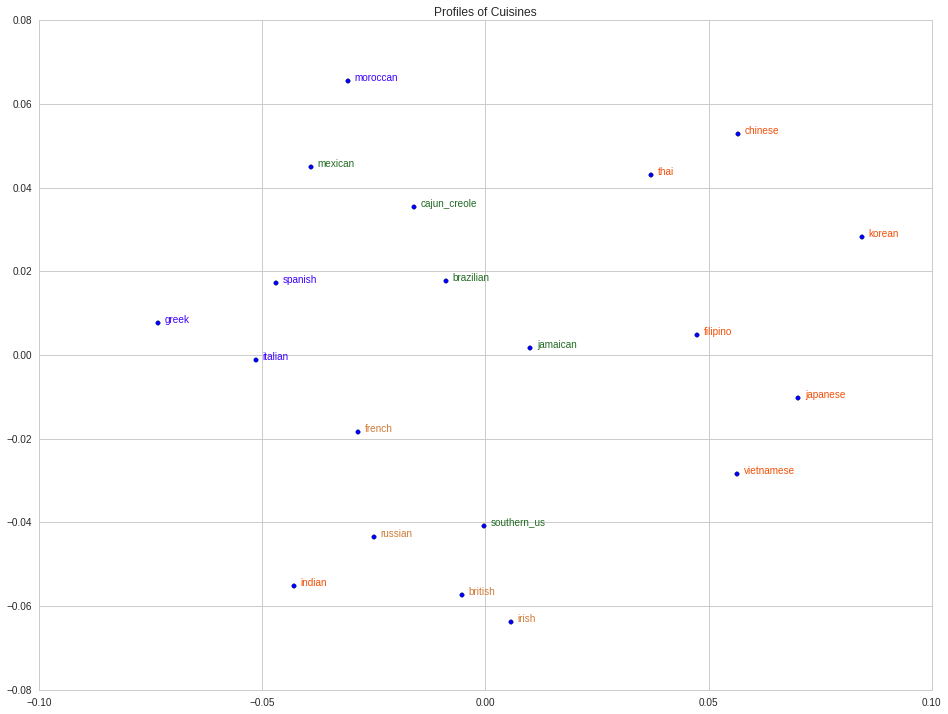

In [13]:
pyl.rcParams['figure.figsize'] = (16.0, 12.0)

fig, ax = plt.subplots()
ax=plt.scatter(x1,y1)
plt.title('Profiles of Cuisines')

colors = {
    'brazilian':    '#216b22',
    'british':      '#ce7a34',
    'cajun_creole': '#216b22',
    'chinese':      '#f24e06',
    'filipino':     '#f24e06',
    'french':       '#ce7a34',
    'greek':        '#3c00ff',
    'indian':       '#f24e06',
    'irish':        '#ce7a34',
    'italian':      '#3c00ff',
    'jamaican':     '#216b22',
    'japanese':     '#f24e06',
    'korean':       '#f24e06',
    'mexican':      '#216b22',
    'moroccan':     '#3c00ff',
    'russian':      '#ce7a34',
    'southern_us':  '#216b22',
    'spanish':      '#3c00ff',
    'thai':         '#f24e06',
    'vietnamese':   '#f24e06'
}

for i, name in enumerate(cuisine_labels):
    plt.annotate(name, (x1[i], y1[i]), color=colors[name], xytext=(7,1), textcoords='offset points')
    
plt.show()

It appears that there is some sort of grouping with ingredients and cuisines. 

# 4. Model Building

The response variable for the model is the **cuisine**.  It is a categorical variable.

The predictor variable is the **ingredients**. It is a list of text. 


![Fig 1. Model Building Approach](https://raw.githubusercontent.com/bluegrapes/DAT8Coursework/master/project2/code/images/approach.png)

##### Data Cleaning

Given that this is a text classification problem. The following data cleaning procedure are performed. 

1. Word replacement. 
2. Stop words. 
3. Stemming words.

##### Feature Engineering

Once the data is cleaned, the following feature engineering are then performed.

1. TFIDF features: ngram_range, min_df, max_df, max_features
2. Regional coding

##### Modeling

The model is subsequently developed following the progression below.  For each model, the approach that I use for selection is one with the highest accuracy score. Score is cross validated across 5 folds. 

1. Logistic Regression.
2. One-vs-Rest
3. Random Forest

##### Model Prediction

The final model is then tested against test data, and prediction is produced against test.json data. 

![Fig 2. Train Test Split](https://raw.githubusercontent.com/bluegrapes/DAT8Coursework/master/project2/code/images/train_test_split.png)



## 4.1. Modeling Data Preparation

In [14]:
# read the data
df = pd.read_json('../data/train.json')

# combine the ingredients list into one sentence
df['ingredients_all'] = df.ingredients.apply(lambda x: " ".join(x))

### 4.1.1. Data Cleaning

The following are performed on the ingredients text:

1. Use of thesauri to clean and replace ingredient.
2. Removing stop words.
3. Stemming the words. 


In [15]:
# replacement data. Philadelphia Cream Cheese -> cream cheese
thesauri = {}
with open("../code/thesauri.txt", "r") as f:
    for line in f:
        entry = line.strip().split(",")
        key = entry[0]
        value = entry[1]
        thesauri[key] = value
f.close()

In [16]:
# custom stop words
stopwords = []
with open("../code/stopwords.txt", "r") as f:
    for line in f:
        stopwords.append(line.strip())
f.close()

In [17]:
# clean ingredients
def clean_ingredients(ingredients):
    stemmer = PorterStemmer()
    new_ingredients = []
    for one in ingredients:
        # if match thesauri, then use its simpler form
        newone = one 
        if one in thesauri:
            newone = thesauri[one]
        # if is not a stop word, then append
        new_ingredients.append(
            " ".join([stemmer.stem(t) for t in word_tokenize(one) if not t in stopwords])
        )
    return new_ingredients

In [18]:
# now do it for all observations
df['ingredients_comma_all'] = df.ingredients.apply(lambda x: ",".join(clean_ingredients(x)))
df['ingredients_all'] = df.ingredients.apply(lambda x: " ".join(clean_ingredients(x)))

In [20]:
print df.ingredients_comma_all[0]
print df.ingredients_all[0]

romain lettuc,black oliv,grape tomato,garlic,pepper,purpl onion,season,garbanzo bean,feta chees crumbl
romain lettuc black oliv grape tomato garlic pepper purpl onion season garbanzo bean feta chees crumbl


Setting the response variable.

In [21]:
# mapping categorical response var
df['cuisine_idx'] = pd.factorize(df['cuisine'])[0]
# set the response variable
y = df['cuisine_idx']

For each model the following function is executed.  It evaluates the accuracy score through cross validation (5 folds).

In [22]:
# cross validate each model
def cross_val_models(models, X, y, K):
    predLst = []
    for model in models:
        score, sem_score = cross_val_validation(model[1], X, y, K)
        predLst.append({'name': model[0],
                        'score': score,
                        'sem' : sem_score})
        print "Cross_val %s...%0.3f" % (model[0], score)
    return predLst

# get the mean score, and standard error mean
def cross_val_validation(clf, X, y, K):
    # create a k-fold cross validation iterator of K folds
    cv = KFold(len(y), K, shuffle=True, random_state=0)
    # get the mean score, and standard error mean
    scores = cross_val_score(clf, X, y, cv=cv, scoring="accuracy")
    return np.mean(scores), sem(scores)


In [23]:
# tokenizer
class Tokenizer(object):
    def __call__(self, doc):
        return doc.split(",")

## 4.2. Logistic Regression Model

For this model, I started out with various base models, choosing one with the best score. And proceeded with feature engineering that will result in an optimum score. 

### 4.2.1. Base models

Evaluate several different models: CountVectorizer, TFIDFVectorizer.

In [24]:
models = [
    ('nb',
        Pipeline([('vect', CountVectorizer(strip_accents='unicode')),
                  ('clf', MultinomialNB())
                 ])
    ),
    ('logistic',
        Pipeline([('vect', TfidfVectorizer(strip_accents='unicode')),
                  ('clf', LogisticRegression(C=1e9))
                 ])
    ),
]
X = df['ingredients_all']
predLst = cross_val_models(models, X, y, 5)
predDf = pd.DataFrame.from_dict(predLst)
predDf

Cross_val nb...0.722
Cross_val logistic...0.742


,name,score,sem
0,nb,0.722482,0.003405
1,logistic,0.742344,0.003009


In [25]:
models = [
    ('logistic_comma',
        Pipeline([('vect', CountVectorizer(strip_accents='unicode')),
                  ('tfidf', TfidfTransformer()),
                  ('clf', LogisticRegression(C=1e9))
                 ])
    ),    
    ('logistic_comma_tokenizer',
        Pipeline([('vect', TfidfVectorizer(strip_accents='unicode', tokenizer=Tokenizer())),
                  ('clf', LogisticRegression(C=1e9))
                 ])        
    ),    
]
X = df['ingredients_comma_all']
predTokenLst = cross_val_models(models, X, y, 5)
predDf = predDf.append(predTokenLst, ignore_index=True)
predDf

Cross_val logistic_comma...0.742
Cross_val logistic_comma_tokenizer...0.651


,name,score,sem
0,nb,0.722482,0.003405
1,logistic,0.742344,0.003009
2,logistic_comma,0.742344,0.003009
3,logistic_comma_tokenizer,0.651154,0.004318


Looks like LogisticRegression with TFIDF has the highest score, **0.742**. 

### 4.2.2. TFIDF features 

Attempting to improve the model by tuning the following parameters:

1. ngram_range. This is for looking at word combination: unigram, bigram, etc.
2. max_features.  
3. min_df, max_df. Tuning these parameters does not improve the score. 

###### 4.2.2.1. NGram_Range

Looking at the vector below, I can surmise that ngram from 2-3 may contribute to a more accurate cuisine prediction.

In [26]:
# vector of ngram for each cuisine
ngram_index = {}
for key, value in ngram_counters.iteritems():
    ngram_index[key] = dict(value)
df_ngram = pd.DataFrame.from_dict(ngram_index, orient='index')
df_ngram = df_ngram.fillna(0)
df_ngram

,1,2,3,4,5,6,7,8,11,9,10,12,13,14
brazilian,217,459,142,28,4,3,0,0,0,0,0,0,0,0
british,269,630,213,46,7,0,0,0,0,0,0,0,0,0
cajun_creole,309,793,336,87,27,14,6,1,0,2,0,0,0,0
chinese,348,908,401,90,21,16,4,2,1,0,0,0,0,0
filipino,213,539,155,28,8,3,1,0,0,0,0,0,0,0
french,478,1074,402,97,33,13,1,1,1,0,0,0,0,0
greek,252,597,260,54,19,7,3,4,0,0,0,0,1,1
indian,341,878,340,78,19,7,0,1,0,0,0,0,0,0
irish,221,549,178,34,11,3,1,1,1,0,0,0,0,0
italian,564,1370,660,190,76,42,14,5,1,5,0,0,1,0


In [27]:
# logistic with (2,3) ngram range
models = [
     ('logistic_ngram_23',
        Pipeline([('vect', TfidfVectorizer(strip_accents='unicode', ngram_range=(2,3))),
                  ('clf', LogisticRegression(C=1e9))
                 ])
    ),    
]
# cross-validate them
X = df['ingredients_all']
pdNGrams = cross_val_models(models, X, y, 5)
predDf = predDf.append(pdNGrams, ignore_index=True)
predDf

Cross_val logistic_ngram_23...0.742


,name,score,sem
0,nb,0.722482,0.003405
1,logistic,0.742344,0.003009
2,logistic_comma,0.742344,0.003009
3,logistic_comma_tokenizer,0.651154,0.004318
4,logistic_ngram_23,0.741565,0.003168


Looks like ngram does not improve the score. 

###### 4.2.2.2. Max_features

Lets look at the max number of features per cuisine. Let's start with te max_features value as the minimum number of ingredients. 

In [28]:
# total number of ingredients per cuisine
total_ingredients_dict = {}
for key, value in cuisine_dict.iteritems():
    total_ingredients_dict[key] = len(value)
# tabulate it
df_total_ingredients = pd.DataFrame.from_dict(total_ingredients_dict, orient='index')
df_total_ingredients = df_total_ingredients.fillna(0)
print df_total_ingredients    
print()
print df_total_ingredients.describe()


                 0
irish          999
mexican       2681
chinese       1791
filipino       947
vietnamese    1108
spanish       1263
japanese      1439
moroccan       974
french        2100
greek         1198
indian        1664
jamaican       877
british       1165
brazilian      853
russian        872
cajun_creole  1575
thai          1376
southern_us   2459
korean         898
italian       2928
()
                0
count    20.00000
mean   1458.35000
std     633.51586
min     853.00000
25%     967.25000
50%    1230.50000
75%    1695.75000
max    2928.00000


In [ ]:
models = [
    ('logistic_max_features',
        Pipeline([('vect', TfidfVectorizer(strip_accents='unicode', max_features=853)),
                  ('clf', LogisticRegression(C=1e9))
                 ])
    )
]
# cross-validate them
X = df['ingredients_all']
pdFeatures = cross_val_models(models, X, y, 5)
predDf = predDf.append(pdFeatures, ignore_index=True)
predDf

The score improved to 0.758.  Let's iterate over from 500 to 2000, incrementing every 250.

In [31]:
# iterating for max features.
models = []
for n in range(500,2000,250):
    models.append(
        ('logistic_max_features_%d' % n,
            Pipeline([('vect', TfidfVectorizer(strip_accents='unicode', max_features=n)),
                  ('clf', LogisticRegression(C=1e9))
                 ])
    ))
# cross-validate them
X = df['ingredients_all']
pdFeatureRanges = cross_val_models(models, X, y, 5)
predDf = predDf.append(pdFeatureRanges, ignore_index=True)
predDf

Cross_val logistic_max_features_500...0.755
Cross_val logistic_max_features_750...0.759
Cross_val logistic_max_features_1000...0.757
Cross_val logistic_max_features_1250...0.753
Cross_val logistic_max_features_1500...0.750
Cross_val logistic_max_features_1750...0.746


,name,score,sem
0,nb,0.722482,0.003405
1,logistic,0.742344,0.003009
2,logistic_comma,0.742344,0.003009
3,logistic_comma_tokenizer,0.651154,0.004318
4,logistic_ngram_23,0.741565,0.003168
5,logistic_max_features,0.758184,0.002056
6,logistic_max_features_500,0.755368,0.001527
7,logistic_max_features_750,0.759139,0.002350
8,logistic_max_features_1000,0.756977,0.002239
9,logistic_max_features_1250,0.752703,0.002706


Using 750 as max_features value improves the score to 0.759. 

### 4.2.3. Regional Coding

In [33]:
# encoding region
df['region'] = df.cuisine.map({
    'brazilian':    1,
    'cajun_creole': 1,
    'jamaican':     1,
    'mexican':      1,
    'southern_us':  1,
    'british':      2,
    'french':       2,
    'russian':      2,
    'irish':        2,
    'chinese':      3,
    'filipino':     3,
    'indian':       3,
    'japanese':     3,
    'korean':       3,
    'thai':         3,
    'vietnamese':   3,
    'greek':        4,
    'italian':      4,
    'moroccan':     4,
    'spanish':      4
})

In [40]:
# feature engineering with regional encoding, let's see if the score improves
# TBD...

## 4.3. One-vs-Rest model

For this model, a One versus the Rest is used.  One-vs-Rest strategy involves training a single classifier per class, with the samples of that class as positive samples and all other samples as negatives.  For each class, the classifier with the highest score,  is used to predict the outcome. 

In [32]:
# evaluating one versus the rest model
models = [
    ('ovr',
        Pipeline([('vect', TfidfVectorizer(strip_accents='unicode')),
                  ('clf', OneVsRestClassifier(LinearSVC(random_state=0)))
                 ])
    ),
    ('ovr_max_features',
        Pipeline([('vect', TfidfVectorizer(strip_accents='unicode', max_features=750)),
                  ('clf', OneVsRestClassifier(LinearSVC(random_state=0)))
                 ])
    ),    
]
X = df['ingredients_all']
predOvr = cross_val_models(models, X, y, 5)
predDf = predDf.append(predOvr, ignore_index=True)
predDf

Cross_val ovr...0.789
Cross_val ovr_max_features...0.778


,name,score,sem
0,nb,0.722482,0.003405
1,logistic,0.742344,0.003009
2,logistic_comma,0.742344,0.003009
3,logistic_comma_tokenizer,0.651154,0.004318
4,logistic_ngram_23,0.741565,0.003168
5,logistic_max_features,0.758184,0.002056
6,logistic_max_features_500,0.755368,0.001527
7,logistic_max_features_750,0.759139,0.002350
8,logistic_max_features_1000,0.756977,0.002239
9,logistic_max_features_1250,0.752703,0.002706


It appears that naive OvR model with TFIDF vectorizer, results in a the higest score of **0.788**. 

## 4.4. Random Forest Model

TBD....

# 5. Model Prediction

In [45]:
# split data to train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [46]:
def train_and_evaluate(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    
    print "Accuracy on training set:"
    print clf.score(X_train, y_train)
    print "Accuracy on testing set:"
    print clf.score(X_test, y_test)
    
    y_pred = clf.predict(X_test)
    print "Classification Report:"
    print metrics.classification_report(y_test, y_pred)
    print "Confusion Matrix:"
    print metrics.confusion_matrix(y_test, y_pred)  

In [47]:
# replicating the best model
model = Pipeline([('vect', TfidfVectorizer(strip_accents='unicode')),
                  ('clf', OneVsRestClassifier(LinearSVC(random_state=0)))
                 ])
# and evaluate
train_and_evaluate(model, X_train, X_test, y_train, y_test)

Accuracy on training set:
0.856788467985
Accuracy on testing set:
0.786102172164
Classification Report:
             precision    recall  f1-score   support

          0       0.80      0.71      0.75       272
          1       0.69      0.82      0.75      1011
          2       0.72      0.62      0.66       186
          3       0.84      0.90      0.87       722
          4       0.78      0.73      0.75       127
          5       0.65      0.44      0.53       253
          6       0.84      0.89      0.86      2012
          7       0.91      0.92      0.91      1629
          8       0.79      0.85      0.82       702
          9       0.53      0.41      0.46       206
         10       0.75      0.78      0.76       372
         11       0.68      0.46      0.55       213
         12       0.76      0.71      0.73       388
         13       0.70      0.53      0.60       108
         14       0.62      0.65      0.63       672
         15       0.85      0.71      0.78     

And using this to predict against test.json data.

In [48]:
# read test.json
testdf = pd.read_json('../data/test.json')

In [51]:
# do the data prep for test.json data
testdf['ingredients_all'] = testdf.ingredients.apply(lambda x: " ".join(clean_ingredients(x)))

In [53]:
# predict it
X1_test = testdf['ingredients_all']
y1_pred = model.predict(X1_test)

In [84]:
idx = testdf.id.values.astype(int)

mapping = {
    0: 'greek',
    1: 'southern_us',
    2: 'filipino',
    3: 'indian',
    4: 'jamaican',
    5: 'spanish',
    6: 'italian',
    7: 'mexican',
    8: 'chinese',
    9: 'british',
    10: 'thai',
    11: 'vietnamese',
    12: 'cajun_creole',
    13: 'brazilian',
    14: 'french',
    15: 'japanese',
    16: 'irish',
    17: 'korean',
    18: 'moroccan',
    19: 'russian'
}  
y1_pred = [mapping[w] for w in y1_pred]

In [87]:
# and generate the output
output_df = pd.DataFrame()
output_df['id'] = idx
output_df['cuisine'] = y1_pred
output_df.to_csv('output.csv',index=False)

Rank 146 as of 20 October 2015

# 7. Conclusion

In this paper, I outline the approach that I took to produce a solution for the [What's Cooking](https://www.kaggle.com/c/whats-cooking) Kaggle competition. 

The approach follows the iterative process of data exploration, data cleaning, feature engineering, modeling, and finally prediction.  

![Fig 3. Process](https://raw.githubusercontent.com/bluegrapes/DAT8Coursework/master/project2/code/images/process.png)

